## Problem Statement Summary: Predicting Demand for Shared Bikes

The task at hand involves building a predictive model for estimating the demand for shared bikes using multiple linear regression. The company, BoomBikes, is experiencing revenue declines due to the ongoing pandemic and aims to revitalize its business strategy post-lockdown. To achieve this, the company seeks to understand the factors influencing bike demand in the American market and leverage this insight to cater to customer needs effectively.

*Key Information*:
- Target Variable: The target variable is represented by the 'cnt' column, which denotes the total number of bike rentals, including both casual and registered users.
- Independent Variables: Various factors affecting bike demand, such as weather conditions ('weathersit'), season ('season'), and year ('yr'), have been gathered through meteorological surveys and market data.
- Goal of the Analysis: The primary objective is to model the demand for shared bikes using the available independent variables. This model will aid management in understanding demand dynamics, devising effective business strategies, and meeting customer expectations post-lockdown.
"""


## Step 1: Reading and Understanding the Data

In [276]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [277]:
# Importing all required packages
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import r2_score
%matplotlib inline

In [278]:
# Read the Data
bike=pd.read_csv("day.csv")

In [279]:
# Check the head of the dataset

bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [280]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [281]:
bike.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [282]:
# dropping the unwanted columns
# instant has only index for the row, dteday has date which can be compensated by year and month column,
# casual and registered seems to be the breakup by category for cnt column.

bike.drop(['instant','dteday','casual','registered'],axis=1,inplace=True)

In [283]:
bike.shape

(730, 12)

In [284]:
bike.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [285]:
# renaming few columns for better readibility

bike.rename(columns={'yr': 'year', 'mnth': 'month', 'hum': 'humidity'}, inplace=True)


In [286]:
bike.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,cnt
0,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [287]:
# Define a mapping dictionary for weathersit with shorter abbreviations
weathersit_mapping = {
    1: 'Clear',
    2: 'Mist',
    3: 'Light Rain',
    4: 'Heavy Rain'
}





# Define a mapping dictionary for season
season_mapping = {
    1: 'spring',
    2: 'summer',
    3: 'fall',
    4: 'winter'
}

weekday_mapping={
    0:'sun',
    1:'mon',
    2:'tue',
    3:'wed',
    4:'thu',
    5:'fri',
    6:'sat'
    }

month_mapping={
    1:'jan',
    2:'feb',
    3:'mar',
    4:'apr',
    5:'may',
    6:'june',
    7:'july',
    8:'aug',
    9:'sep',
    10:'oct',
    11:'nov',
    12:'dec'

}


In [288]:
# Convert numerical values to categorical string values
bike['weathersit'] = bike['weathersit'].map(weathersit_mapping)
bike['season'] = bike['season'].map(season_mapping)
bike["weekday"]=bike["weekday"].map(weekday_mapping)
bike["month"]=bike["month"].map(month_mapping)

In [289]:
bike.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,cnt
0,spring,0,jan,0,mon,1,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,tue,1,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,wed,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,thu,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,fri,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


From your analysis of the categorical variables from the dataset, what could you infer about 
their effect on the dependent variable?  

#### Visualising Numeric Variables

Let's make a pairplot of all the numeric variables

In [290]:
# sns.pairplot(bike)
# plt.show()

# Insight
- 

In [291]:

def plot_cat_columns(cat_columns, data):
    num_columns = len(cat_columns)
    num_rows = num_columns
    num_cols = 2
    
    # Set up the figure and axes
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    
    # Iterate over categorical columns
    for i, column in enumerate(cat_columns):
        # Calculate mean values for each category and sort in descending order
        mean_values = data.groupby(column)['cnt'].mean().sort_values(ascending=False)
        
        # Plot without hue
        plt.subplot(num_rows, num_cols, i*2+1)
        sns.barplot(x=mean_values.index, y=mean_values.values, palette='Set1')
        plt.title(f'Bar Plot of {column} vs cnt')
        plt.xlabel(column)
        plt.ylabel('cnt')
        
        # Plot with hue='year'
        plt.subplot(num_rows, num_cols, i*2+2)
        sns.barplot(x=column, y='cnt', data=data, hue='year', palette='Set1', order=mean_values.index)
        plt.title(f'Bar Plot of {column} vs cnt (wrt Year)')
        plt.xlabel(column)
        plt.legend(labels=['2018', '2019'])  # Adding legend
        
    plt.tight_layout()





In [292]:
def plot_cat_columns(cat_columns, data):
    num_columns = len(cat_columns)
    num_rows = num_columns
    num_cols = 2
    
    # Set up the figure and axes
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    
    # Iterate over categorical columns
    for i, column in enumerate(cat_columns):
        # Calculate mean values for each category and sort in descending order
        mean_values = data.groupby(column)['cnt'].mean().sort_values(ascending=False)
        
        # Plot without hue
        plt.subplot(num_rows, num_cols, i*2+1)
        sns.barplot(x=mean_values.index, y=mean_values.values, palette='Set1')
        plt.title(f'Bar Plot of {column} vs cnt')
        plt.xlabel(column)
        plt.ylabel('cnt')
        
        # Plot with hue='year'
        plt.subplot(num_rows, num_cols, i*2+2)
        sns.barplot(x=column, y='cnt', data=data, hue='year', palette='Set1', order=mean_values.index)
        plt.title(f'Bar Plot of {column} vs cnt (wrt Year)')
        plt.xlabel(column)
        handles, labels = plt.gca().get_legend_handles_labels()
        custom_handles = [plt.Line2D([0], [0], color='red', lw=4), plt.Line2D([0], [0], color='blue', lw=4)]
        plt.legend(custom_handles, ['2018', '2019'])

    plt.tight_layout()




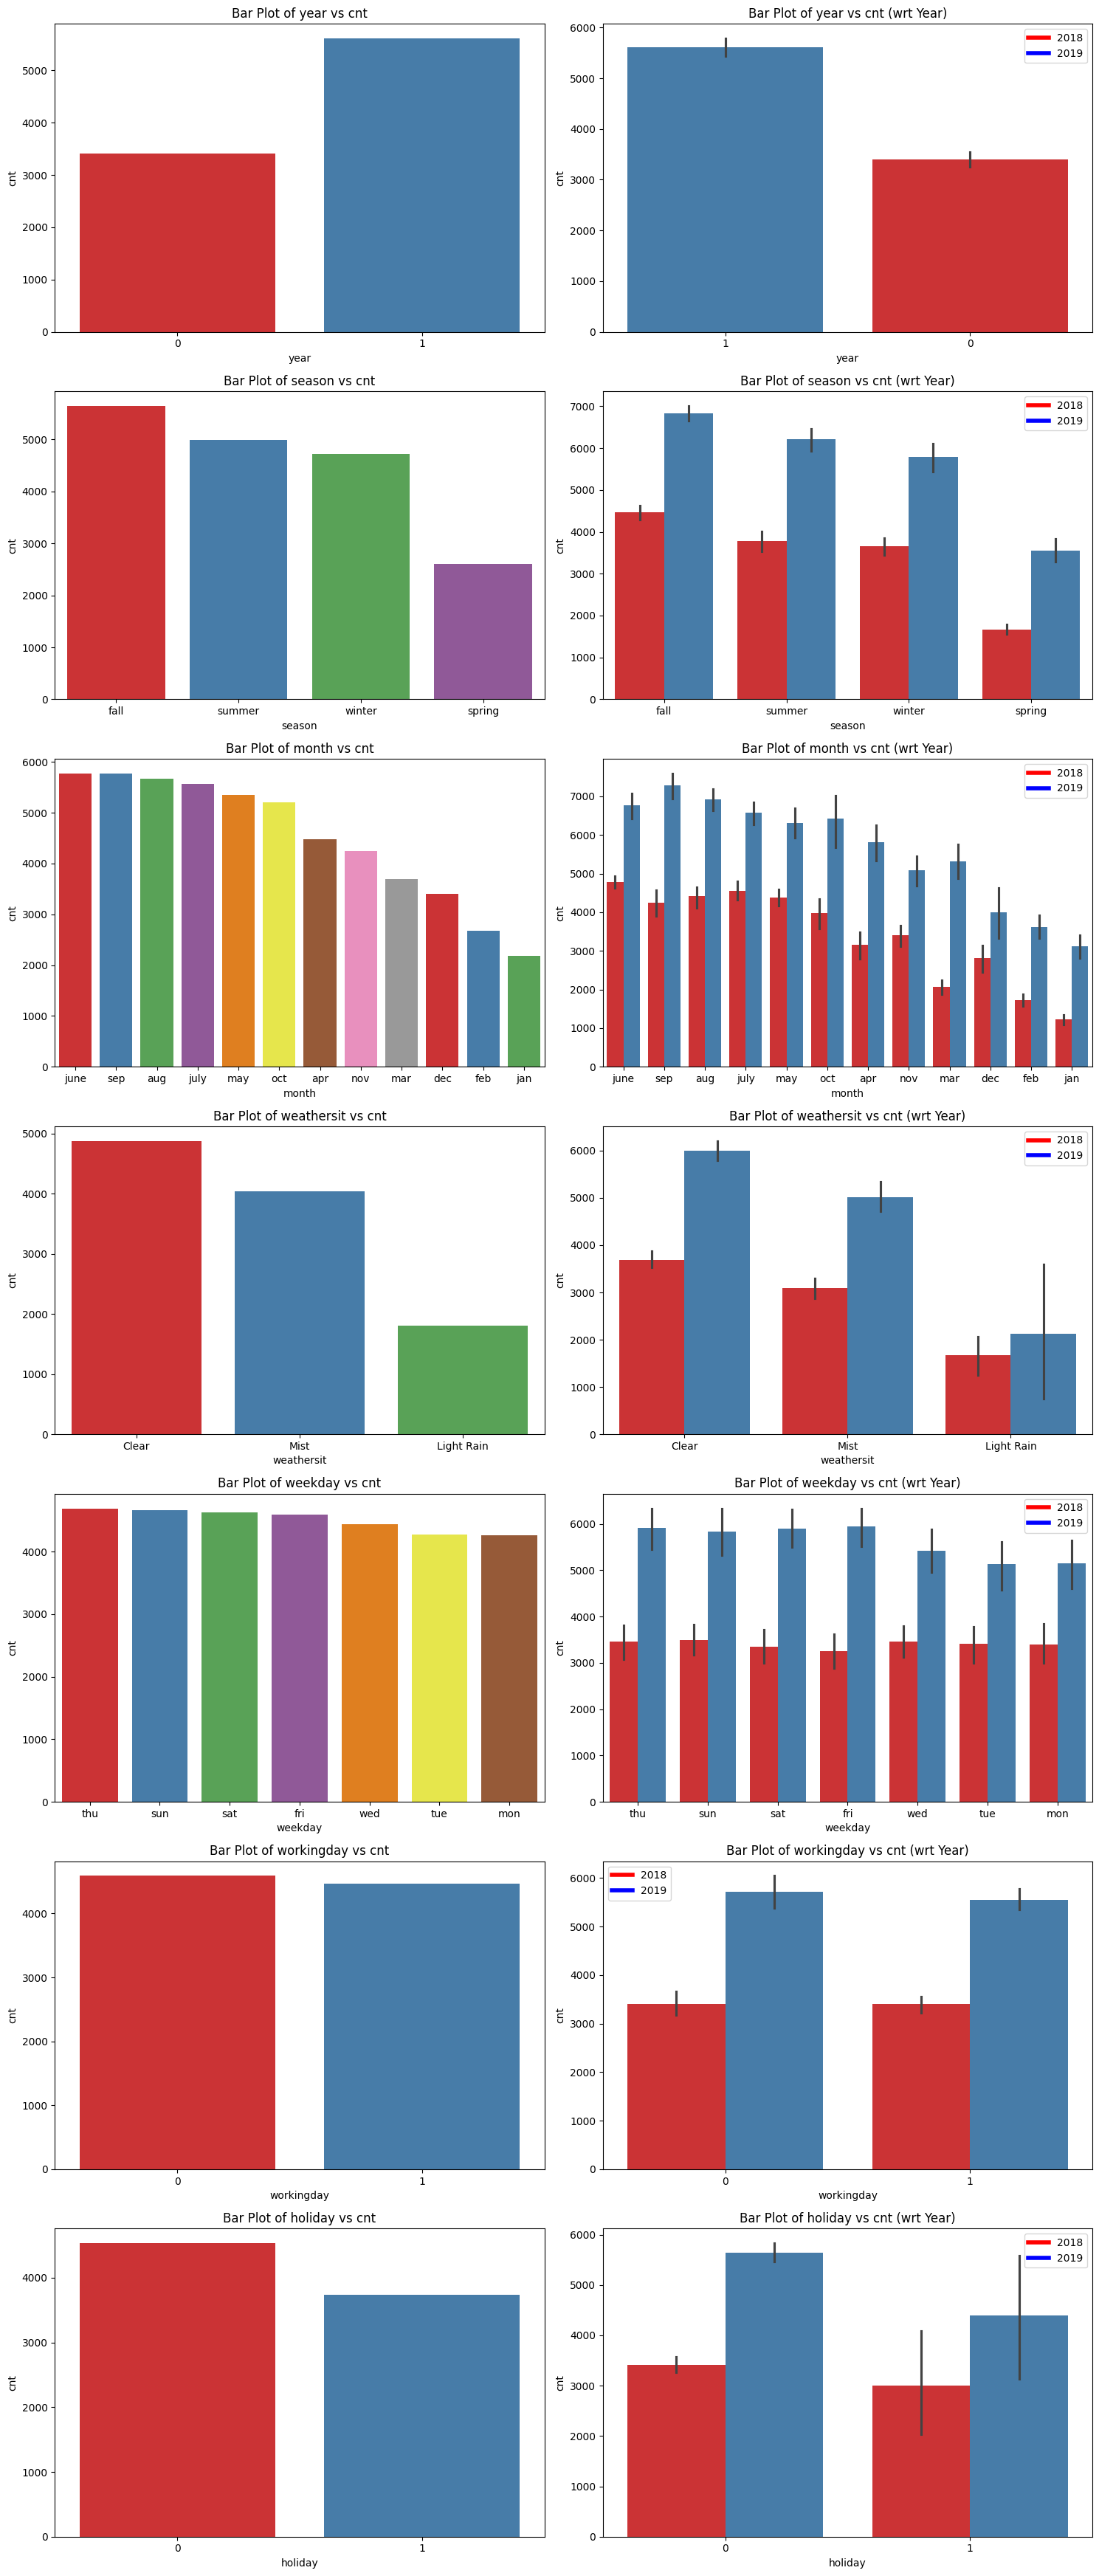

In [293]:
# Assuming 'bike' is your DataFrame
plot_cat_columns(["year",'season', 'month', 'weathersit', 'weekday',"workingday","holiday"], bike)

Insights

1. Over all count of total rental bikes have increased from 2018 to 2019
2. Fall season is the most favourable time when people are renting bikes for both the years with spring season the least. 
3. June, September, August Month are the months with highest rentals with December, Jan and Feb with the least. 
4. When the weather is clear people are renting the bikes highest with nill during heavy rain and very less during light rain
5. Thursay to Sunday people are renting the bikes frequently but the number drops between monday to wednesday
6. Intrestingly the count of total rental come down for weekends and holiday in 2019 compared to 2018.

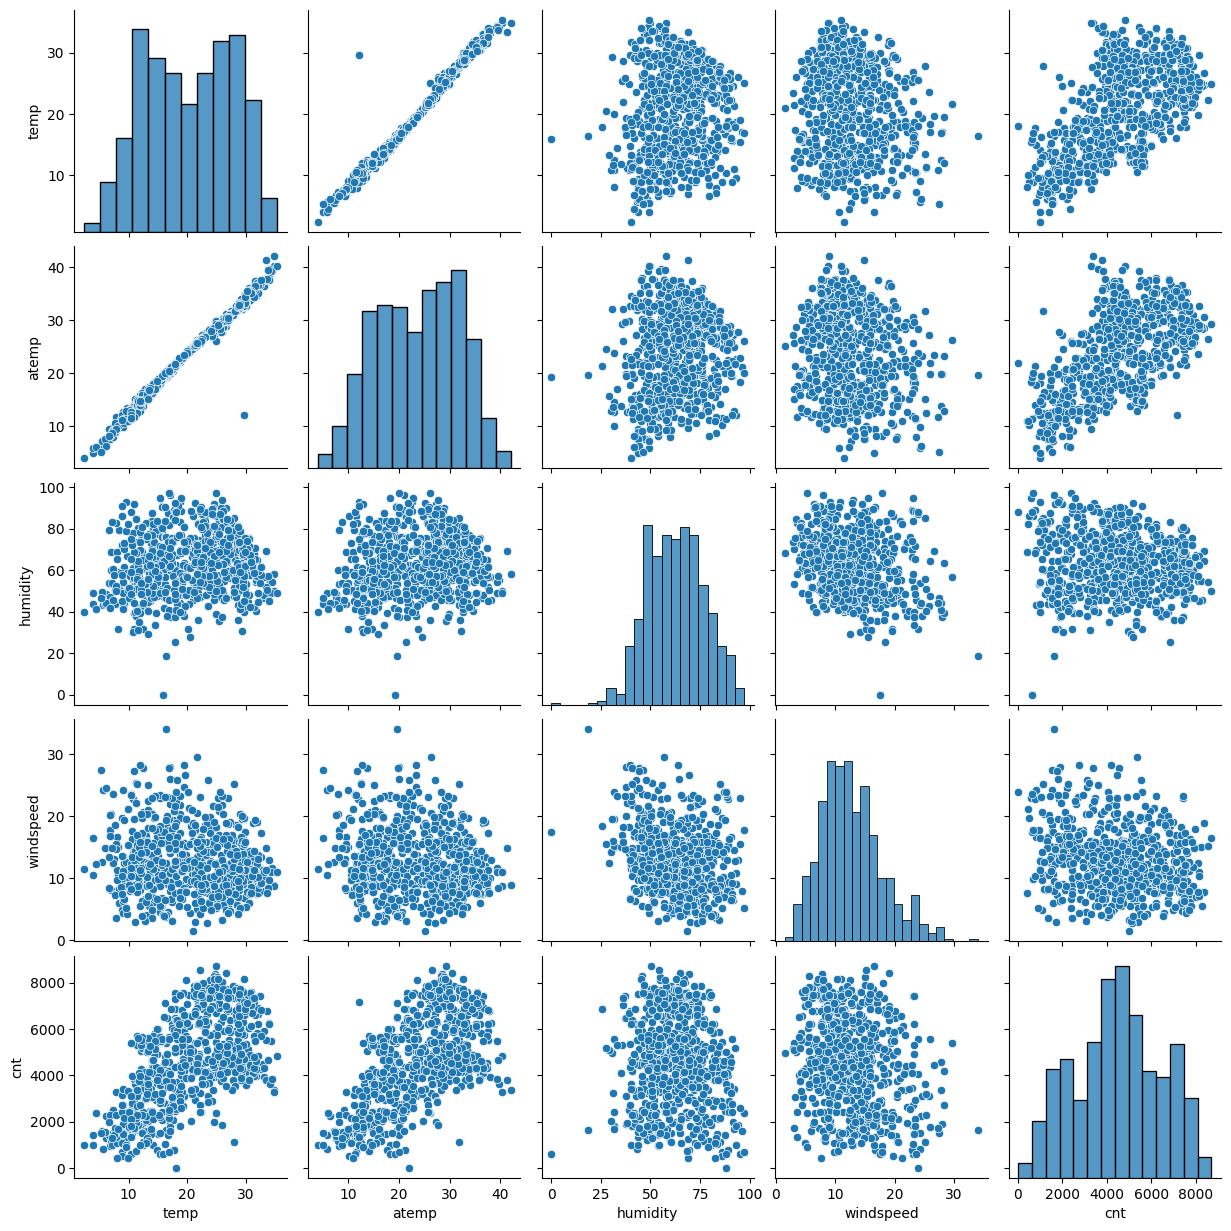

In [294]:
# Create the pair plot
sns.pairplot(data=bike,vars=["temp","atemp","humidity","windspeed","cnt"])
plt.show()

In [295]:
bike.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,cnt
0,spring,0,jan,0,mon,1,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,tue,1,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,wed,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,thu,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,fri,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [296]:
bike.dtypes

season         object
year            int64
month          object
holiday         int64
weekday        object
workingday      int64
weathersit     object
temp          float64
atemp         float64
humidity      float64
windspeed     float64
cnt             int64
dtype: object

In [297]:
# Dummy variable creation for month, weekday, weathersit and season variables and dropping those columns



def create_dummy_variables(data, columns):
    """
    Create dummy variables for the specified categorical columns in the DataFrame and drop the original columns.
    
    Parameters:
    data (DataFrame): The input DataFrame.
    columns (list): List of column names for which dummy variables should be created.
    
    Returns:
    DataFrame: The DataFrame with dummy variables created and original columns dropped.
    """
    # Create dummy variables for each column in the list
    dummy_variables = pd.get_dummies(data[columns], drop_first=True, dtype=int, prefix='', prefix_sep='')
    
    # Drop original categorical columns from the DataFrame
    data.drop(columns, axis=1, inplace=True)
    
    # Concatenate dummy variables with the DataFrame
    data = pd.concat([data, dummy_variables], axis=1)
    
    return data




In [298]:
bike = create_dummy_variables(bike, ['month', 'weekday', 'weathersit', 'season'])


In [299]:
num_cols = [col for col in bike.columns if bike[col].dtype != 'O']

In [300]:
num_cols

['year',
 'holiday',
 'workingday',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'cnt',
 'aug',
 'dec',
 'feb',
 'jan',
 'july',
 'june',
 'mar',
 'may',
 'nov',
 'oct',
 'sep',
 'mon',
 'sat',
 'sun',
 'thu',
 'tue',
 'wed',
 'Light Rain',
 'Mist',
 'spring',
 'summer',
 'winter']

Insight:

Both ```temp``` and ```atemp``` cannot be used in the model due to multicolinearity as there is 99% correlation between them. We will decide which parameters to keep based on VIF and p-value w.r.t other variables

## Step 3: Data Preparation

In [301]:
# Dummy variable creation for month, weekday, weathersit and season variables and dropping those columns



def create_dummy_variables(data, columns):
    """
    Create dummy variables for the specified categorical columns in the DataFrame and drop the original columns.
    
    Parameters:
    data (DataFrame): The input DataFrame.
    columns (list): List of column names for which dummy variables should be created.
    
    Returns:
    DataFrame: The DataFrame with dummy variables created and original columns dropped.
    """
    # Create dummy variables for each column in the list
    dummy_variables = pd.get_dummies(data[columns], drop_first=True, dtype=int, prefix='', prefix_sep='')
    
    # Drop original categorical columns from the DataFrame
    data.drop(columns, axis=1, inplace=True)
    
    # Concatenate dummy variables with the DataFrame
    data = pd.concat([data, dummy_variables], axis=1)
    
    return data




In [302]:
bike.head()

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt,aug,dec,...,sat,sun,thu,tue,wed,Light Rain,Mist,spring,summer,winter
0,0,0,1,14.110847,18.18125,80.5833,10.749882,985,0,0,...,0,0,0,0,0,0,1,1,0,0
1,0,0,1,14.902598,17.68695,69.6087,16.652113,801,0,0,...,0,0,0,1,0,0,1,1,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,...,0,0,0,0,1,0,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,...,0,0,0,0,0,0,0,1,0,0


In [303]:
bike.columns

Index(['year', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'cnt', 'aug', 'dec', 'feb', 'jan', 'july', 'june', 'mar',
       'may', 'nov', 'oct', 'sep', 'mon', 'sat', 'sun', 'thu', 'tue', 'wed',
       'Light Rain', 'Mist', 'spring', 'summer', 'winter'],
      dtype='object')

In [304]:
bike.shape

(730, 30)

In [305]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        730 non-null    int64  
 1   holiday     730 non-null    int64  
 2   workingday  730 non-null    int64  
 3   temp        730 non-null    float64
 4   atemp       730 non-null    float64
 5   humidity    730 non-null    float64
 6   windspeed   730 non-null    float64
 7   cnt         730 non-null    int64  
 8   aug         730 non-null    int32  
 9   dec         730 non-null    int32  
 10  feb         730 non-null    int32  
 11  jan         730 non-null    int32  
 12  july        730 non-null    int32  
 13  june        730 non-null    int32  
 14  mar         730 non-null    int32  
 15  may         730 non-null    int32  
 16  nov         730 non-null    int32  
 17  oct         730 non-null    int32  
 18  sep         730 non-null    int32  
 19  mon         730 non-null    i

## Step 4: Splitting the Data into Training and Testing Sets

As you know, the first basic step for regression is performing a train-test split.

## Step 4: Splitting the Data into Training and Testing Sets

In [306]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
bike_train, bike_test = train_test_split(bike, train_size = 0.7, test_size = 0.3, random_state = 42)

### Rescaling the Features 



In [307]:
# Apply scaler() to all the columns except the '1-0' and 'dummy' variables


def non_categorical_non_binary_columns(data):
    non_cat_non_binary_columns = []
    for column in data.columns:
        if data[column].dtype in ["int32",'int64', 'float64']:  # Check if the column is numerical
            unique_values = data[column].unique()
            if len(unique_values) > 2 or not all(value in [0, 1] for value in unique_values):  # Check if unique values are not only 0 and 1
                non_cat_non_binary_columns.append(column)
    return non_cat_non_binary_columns

# Usage
num_vars = non_categorical_non_binary_columns(bike)
print(num_vars)



['temp', 'atemp', 'humidity', 'windspeed', 'cnt']


In [308]:
scaler = MinMaxScaler()

bike_train[num_vars] = scaler.fit_transform(bike_train[num_vars])

In [309]:
bike_train.head()

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt,aug,dec,...,sat,sun,thu,tue,wed,Light Rain,Mist,spring,summer,winter
683,1,0,1,0.327133,0.322150,0.639330,0.327101,0.605336,0,0,...,0,0,0,0,0,0,1,0,0,1
645,1,1,0,0.403972,0.404998,0.731215,0.419004,0.609320,0,0,...,0,0,0,1,0,0,1,0,0,1
163,0,0,1,0.717562,0.685963,0.509660,0.708724,0.554026,0,0,...,0,0,0,0,1,0,0,0,1,0
360,0,0,1,0.331287,0.326273,0.785745,0.415925,0.088253,0,1,...,0,0,1,0,0,0,1,1,0,0
640,1,0,1,0.745598,0.682653,0.817947,0.110593,0.862127,0,0,...,0,0,1,0,0,0,1,0,0,1


In [310]:
bike_train.describe()

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt,aug,dec,...,sat,sun,thu,tue,wed,Light Rain,Mist,spring,summer,winter
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.521569,0.027451,0.698039,0.551091,0.526680,0.653801,0.414566,0.498206,0.074510,0.074510,...,0.143137,0.133333,0.135294,0.156863,0.133333,0.029412,0.345098,0.231373,0.256863,0.250980
std,0.500025,0.163554,0.459559,0.227401,0.213153,0.143542,0.185671,0.233905,0.262857,0.262857,...,0.350557,0.340268,0.342373,0.364028,0.340268,0.169124,0.475867,0.422124,0.437332,0.434003
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.354176,0.352585,0.544033,0.281934,0.345950,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.575824,0.564951,0.659296,0.383964,0.502233,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.745338,0.698389,0.756762,0.525698,0.677080,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Top 10 correlations:
    Feature1    Feature2  Correlation
123    atemp        temp     0.996588
814   spring       atemp     0.646852
214      cnt       atemp     0.641676
813   spring        temp     0.639100
213      cnt        temp     0.633771
602      sat  workingday     0.621420
817   spring         cnt     0.598976


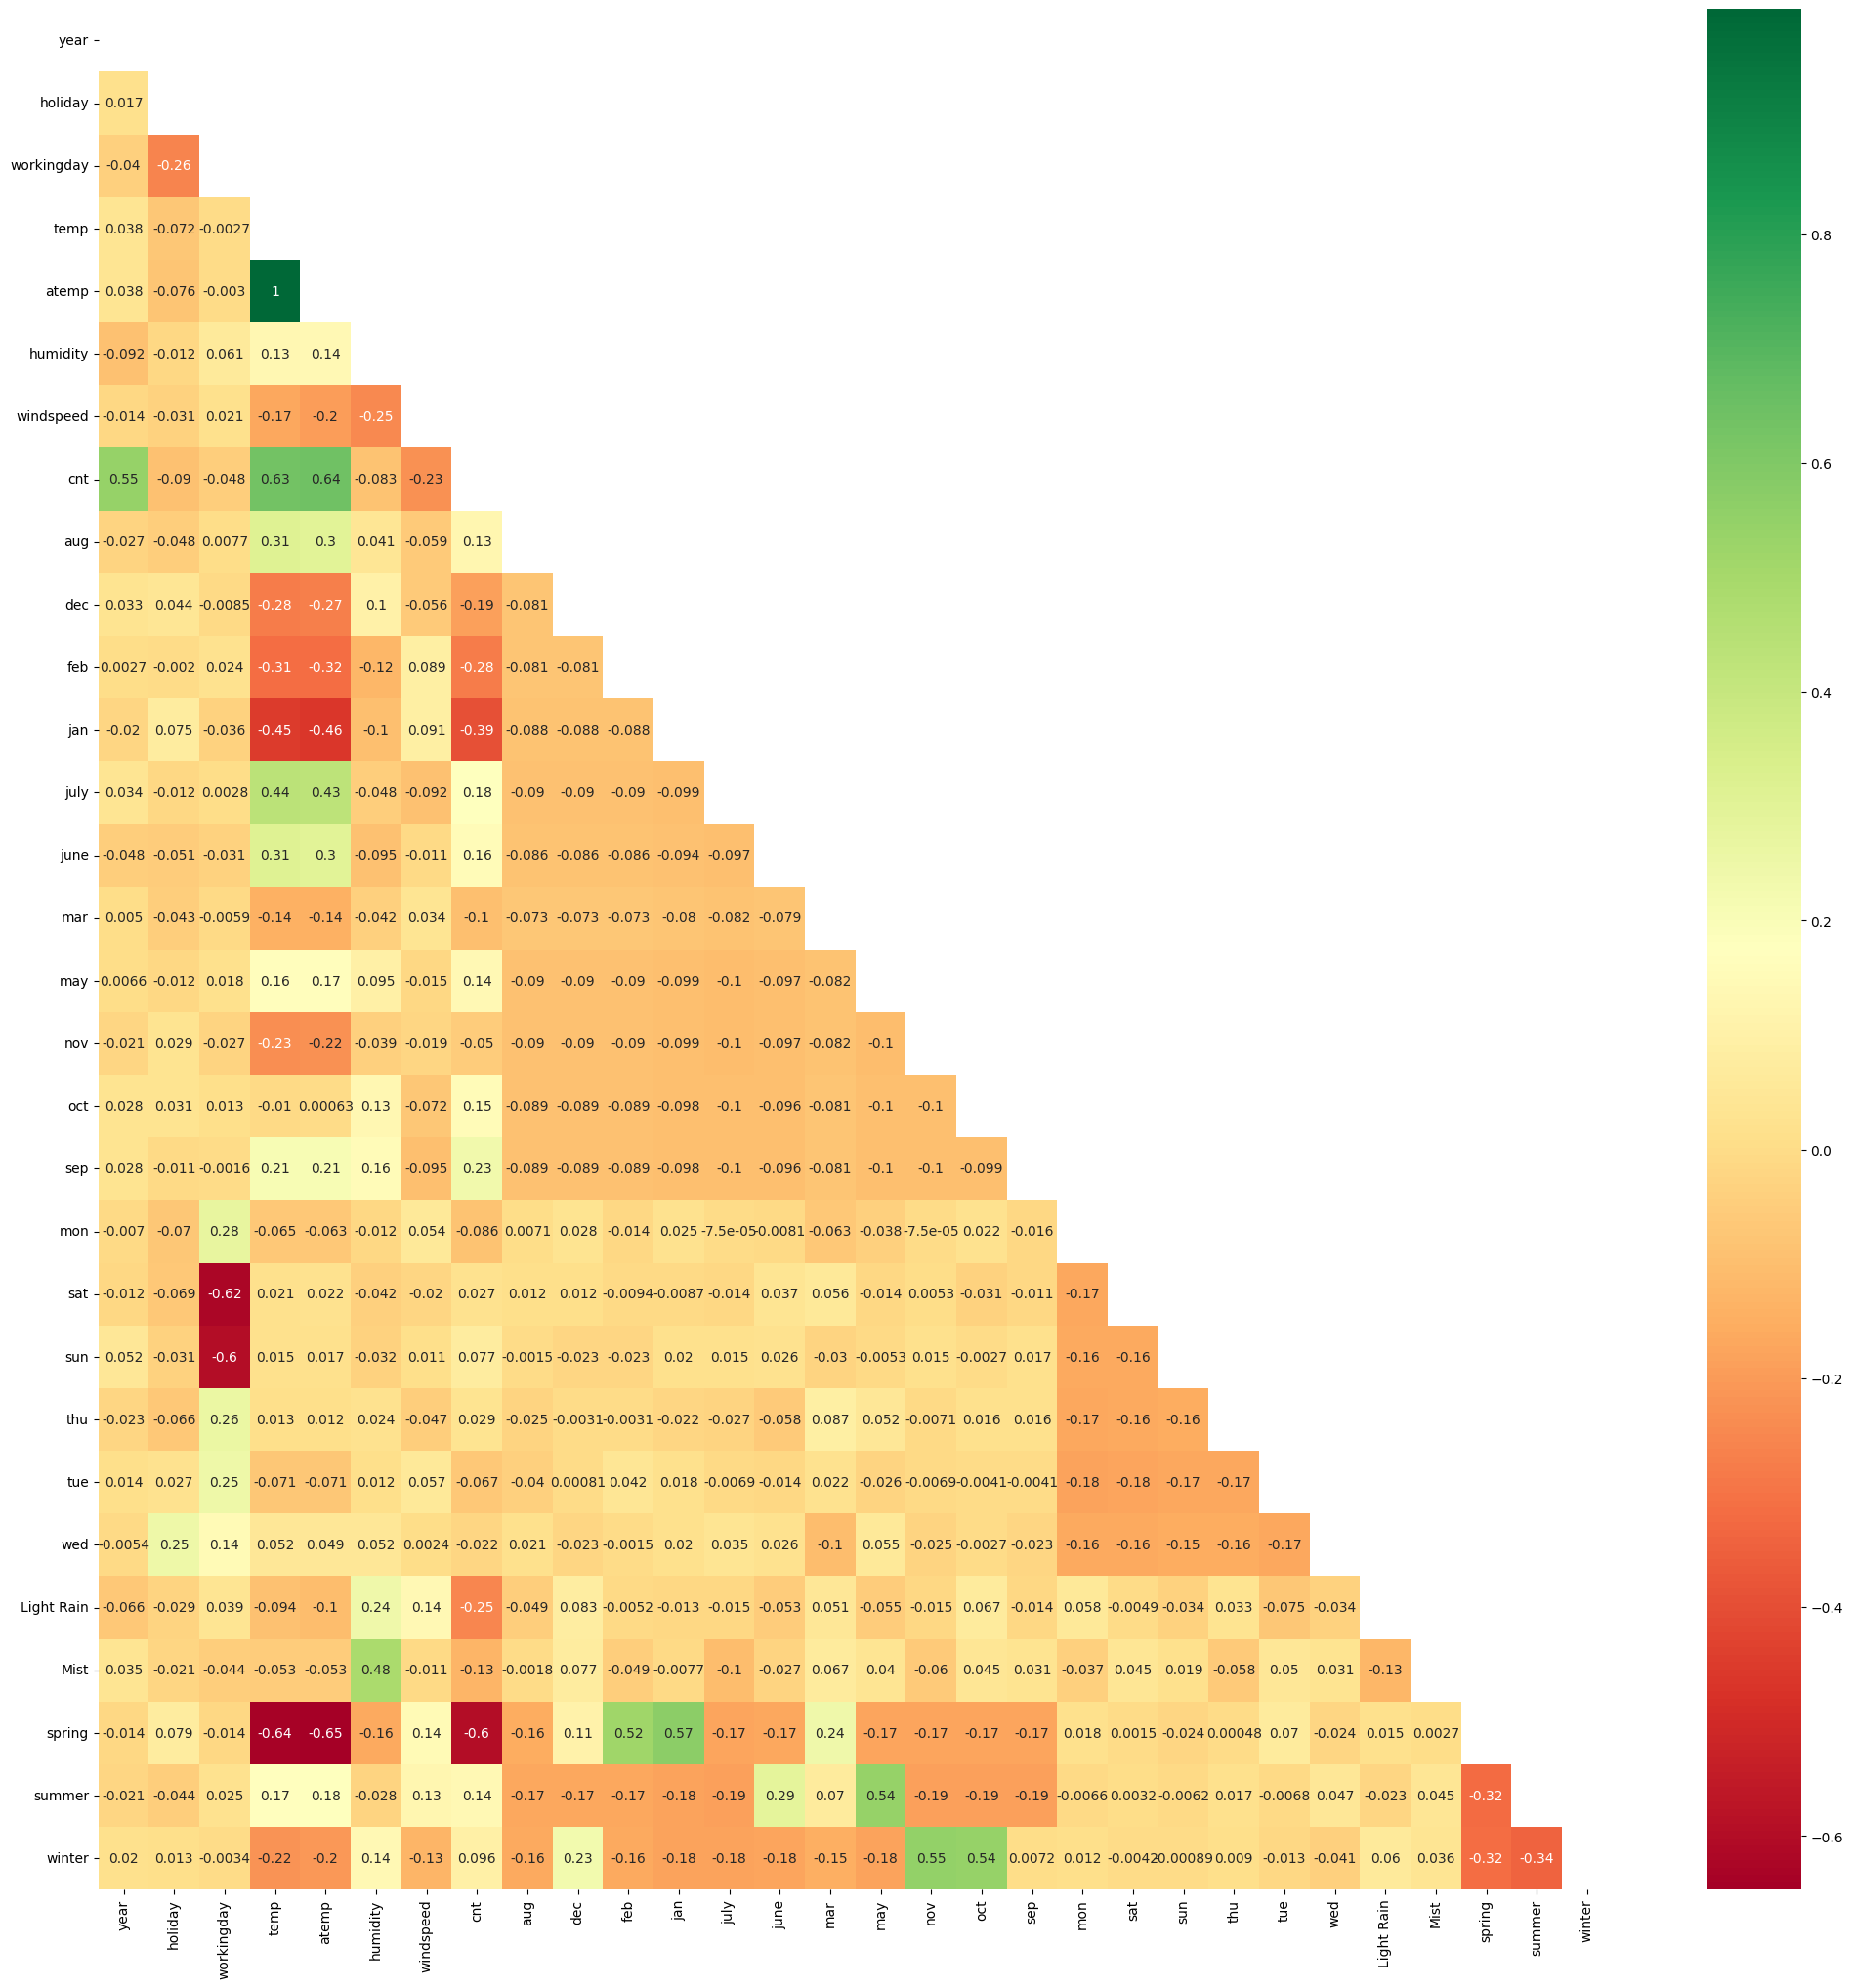

In [311]:
# Let's check the correlation coefficients to see which variables are highly correlated


# Compute the correlation matrix
corr_Defaulter = bike_train.corr()

# Use np.bool_ instead of np.bool
corr_Defaulter = corr_Defaulter.where(np.triu(np.ones(corr_Defaulter.shape), k=1).astype(np.bool_))

# Unstack and reset index
corr_df_Defaulter = corr_Defaulter.unstack().reset_index()
corr_df_Defaulter.columns = ['Feature1', 'Feature2', 'Correlation']

# Drop NaN values
corr_df_Defaulter.dropna(subset=["Correlation"], inplace=True)

# Take absolute values of correlations
corr_df_Defaulter["Correlation"] = corr_df_Defaulter["Correlation"].abs()

# Sort values by correlation
corr_df_Defaulter.sort_values(by='Correlation', ascending=False, inplace=True)

# Get top 10 correlations
top_correlations = corr_df_Defaulter.head(7)

print("Top 10 correlations:")
print(top_correlations)

# Plot the heatmap
plt.figure(figsize=(25, 25))
matrix = np.triu(bike_train.corr())
sns.heatmap(bike_train.corr(), annot=True, cmap="RdYlGn", mask=matrix)
plt.show()


As you might have noticed, `atemp`, `temp`,"`spring` to the correlated to `cnt` the most. Also they all three themselves have strong correraltion which give indications of multicolaratery

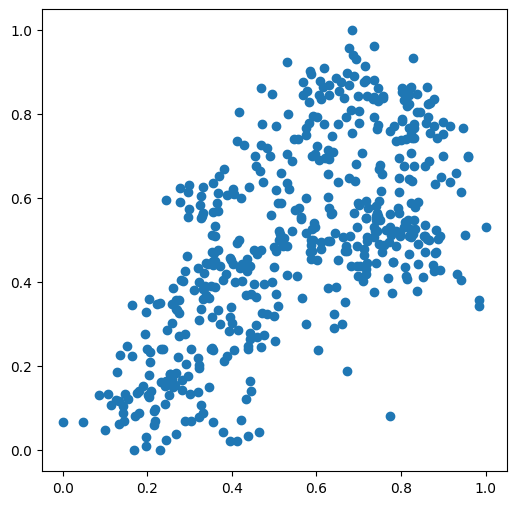

In [312]:
# Visualizing one of the correlation to see the trends via Scatter plot.

plt.figure(figsize=[6,6])
plt.scatter(bike_train.temp, bike_train.cnt)
plt.show()

Visualization confirms the positive correlation between ```temp``` and ```cnt```.

So, we pick `temp` as the first variable and we'll try to fit a regression line to that.

### Dividing into X and Y sets for the model building

In [313]:
y_train = bike_train.pop('cnt')
X_train = bike_train

## Step 5: Building a linear model

This time, we will be using the **LinearRegression function from SciKit Learn** for its compatibility with RFE (which is a utility from sklearn)

In [314]:
X_train.shape

(510, 29)

In [315]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [316]:

# Assuming X_train and y_train are already defined
lm = LinearRegression()
rfe = RFE(estimator=lm, n_features_to_select=15)  # running RFE
rfe = rfe.fit(X_train, y_train)

# Get the selected feature indices
selected_features = rfe.support_

# Get the ranking of the features
feature_ranking = rfe.ranking_



In [317]:
#List of variables selected in top 15 list

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('year', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 10),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('humidity', True, 1),
 ('windspeed', True, 1),
 ('aug', False, 12),
 ('dec', True, 1),
 ('feb', False, 8),
 ('jan', False, 14),
 ('july', True, 1),
 ('june', False, 9),
 ('mar', True, 1),
 ('may', False, 2),
 ('nov', True, 1),
 ('oct', False, 3),
 ('sep', True, 1),
 ('mon', False, 4),
 ('sat', False, 11),
 ('sun', False, 13),
 ('thu', False, 15),
 ('tue', False, 6),
 ('wed', False, 5),
 ('Light Rain', True, 1),
 ('Mist', True, 1),
 ('spring', True, 1),
 ('summer', False, 7),
 ('winter', True, 1)]

In [318]:
col = X_train.columns[rfe.support_]
col

Index(['year', 'holiday', 'temp', 'atemp', 'humidity', 'windspeed', 'dec',
       'july', 'mar', 'nov', 'sep', 'Light Rain', 'Mist', 'spring', 'winter'],
      dtype='object')

In [319]:
X_train.columns[~rfe.support_]

Index(['workingday', 'aug', 'feb', 'jan', 'june', 'may', 'oct', 'mon', 'sat',
       'sun', 'thu', 'tue', 'wed', 'summer'],
      dtype='object')

In [320]:
# Generic function to calculate VIF of variables

def calculateVIF(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif 

In [321]:
# dataframe with RFE selected variables

X_train_rfe = X_train[col]

In [322]:
# calculate VIF

calculateVIF(X_train_rfe)

,Features,VIF
3,atemp,1234.24
2,temp,1206.36
4,humidity,25.49
5,windspeed,5.35
14,winter,2.77
13,spring,2.76
12,Mist,2.26
0,year,2.10
9,nov,1.84
7,july,1.49


## Step 5: Building a linear model

##### Building 1st Linear Regression Model

In [323]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm_1 = sm.add_constant(X_train_rfe)


In [324]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [325]:
lr_1 = sm.OLS(y_train,X_train_lm_1).fit()


In [326]:
#Let's see the summary of our linear model
print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     172.9
Date:                Wed, 29 May 2024   Prob (F-statistic):          1.74e-185
Time:                        01:09:42   Log-Likelihood:                 485.12
No. Observations:                 510   AIC:                            -938.2
Df Residuals:                     494   BIC:                            -870.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3371      0.037      9.180      0.0

# Insight 

Since ```atemp```,```temp``` has P value>0.05 we are going to drop these columns`

In [327]:
X_train_new = X_train_rfe.drop(["atemp","temp"], axis = 1)

In [328]:
# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
2,humidity,7.64
3,windspeed,4.61
12,winter,2.56
0,year,2.02
10,Mist,1.93
7,nov,1.77
11,spring,1.70
4,dec,1.33
5,july,1.25
8,sep,1.23


##### Building 2nd linear regression model


In [329]:

X_train_lm_2 = sm.add_constant(X_train_new)
lr_2 = sm.OLS(y_train,X_train_lm_2).fit()
print(lr_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     143.1
Date:                Wed, 29 May 2024   Prob (F-statistic):          2.29e-158
Time:                        01:11:16   Log-Likelihood:                 415.12
No. Observations:                 510   AIC:                            -802.2
Df Residuals:                     496   BIC:                            -742.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5928      0.035     17.025      0.0

Since ```humidity ```,```july``` has P value>0.05 we are going to drop these columns`

In [331]:
X_train_new = X_train_new.drop(["humidity","july"],axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
2,windspeed,2.64
10,winter,2.32
0,year,1.87
5,nov,1.77
9,spring,1.61
8,Mist,1.52
3,dec,1.32
4,mar,1.16
6,sep,1.13
7,Light Rain,1.10


##### Building 3rd linear regression model


In [332]:

X_train_lm_3 = sm.add_constant(X_train_new)
lr_3 = sm.OLS(y_train,X_train_lm_3).fit()
print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     168.1
Date:                Wed, 29 May 2024   Prob (F-statistic):          8.96e-160
Time:                        01:16:47   Log-Likelihood:                 413.17
No. Observations:                 510   AIC:                            -802.3
Df Residuals:                     498   BIC:                            -751.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5497      0.015     37.862      0.0

# Insight 

- Since ```mar```has P value>0.05 we are going to drop this column

In [333]:
X_train_new = X_train_new.drop("mar", axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
2,windspeed,2.64
9,winter,2.32
0,year,1.87
4,nov,1.77
8,spring,1.52
7,Mist,1.51
3,dec,1.31
5,sep,1.13
6,Light Rain,1.09
1,holiday,1.04


##### Building 4rth  linear regression model


In [334]:

X_train_lm_4 = sm.add_constant(X_train_new)
lr_4 = sm.OLS(y_train,X_train_lm_4).fit()
print(lr_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     183.0
Date:                Wed, 29 May 2024   Prob (F-statistic):          7.50e-160
Time:                        01:18:24   Log-Likelihood:                 410.64
No. Observations:                 510   AIC:                            -799.3
Df Residuals:                     499   BIC:                            -752.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5520      0.015     37.954      0.0

# Insight 

- Since ```winter```has P value>0.05 we are going to drop this column

In [335]:
X_train_new = X_train_new.drop("winter", axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
2,windspeed,2.59
0,year,1.84
7,Mist,1.48
8,spring,1.42
4,nov,1.13
3,dec,1.12
5,sep,1.12
6,Light Rain,1.08
1,holiday,1.04


##### Building 5th linear regression model


In [337]:
X_train_lm_5=sm.add_constant(X_train_new)
lr_5=sm.OLS(y_train,X_train_lm_5).fit()

In [338]:
print(lr_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     202.7
Date:                Wed, 29 May 2024   Prob (F-statistic):          1.42e-160
Time:                        01:24:25   Log-Likelihood:                 409.59
No. Observations:                 510   AIC:                            -799.2
Df Residuals:                     500   BIC:                            -756.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5570      0.014     39.461      0.0

In [339]:
calculateVIF(X_train_new)

,Features,VIF
2,windspeed,2.59
0,year,1.84
7,Mist,1.48
8,spring,1.42
4,nov,1.13
3,dec,1.12
5,sep,1.12
6,Light Rain,1.08
1,holiday,1.04


Since now for each feature p value< 0.05 and VIF<10 we can cosider the above model i.e lr_5, as it seems to have very low multicolinearity between the predictors and the p-values for all the predictors seems to be significant.

In [340]:
# Checking the parameters and their coefficient values
lr_5.params

const         0.557047
year          0.247042
holiday      -0.081637
windspeed    -0.147256
dec          -0.106306
nov          -0.125097
sep           0.069920
Light Rain   -0.288665
Mist         -0.087635
spring       -0.313460
dtype: float64

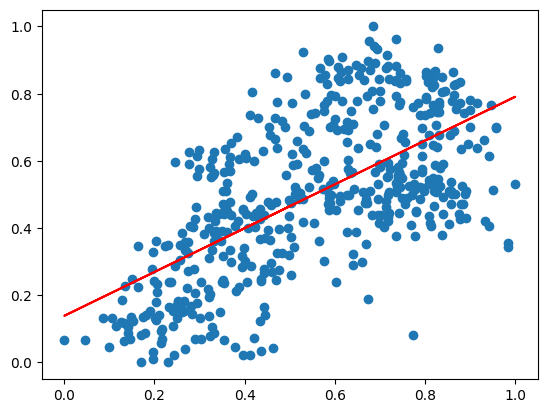

In [ ]:
# Let's visualise the data with a scatter plot and the fitted regression line
plt.scatter(X_train_lm.iloc[:, 1], y_train)
plt.plot(X_train_lm.iloc[:, 1], 0.138950 + 0.651899* X_train_lm.iloc[:, 1], 'r')
plt.show()

In [ ]:
# Print a summary of the linear regression model obtained
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     341.0
Date:                Tue, 28 May 2024   Prob (F-statistic):           1.23e-58
Time:                        20:29:39   Log-Likelihood:                 148.76
No. Observations:                 510   AIC:                            -293.5
Df Residuals:                     508   BIC:                            -285.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1390      0.021      6.603      0.0

---
## Step 3: Performing Simple Linear Regression

Equation of linear regression<br>
$y = c + m_1x_1 + m_2x_2 + ... + m_nx_n$

-  $y$ is the response
-  $c$ is the intercept
-  $m_1$ is the coefficient for the first feature
-  $m_n$ is the coefficient for the nth feature<br>

In our case:

$y = c + m_1 \times TV$

The $m$ values are called the model **coefficients** or **model parameters**.

---

### Generic Steps in model building using `statsmodels`

We first assign the feature variable, `registered`, in this case, to the variable `X` and the response variable, `cnt`, to the variable `y`.

In [ ]:
X = bike['registered']
y = bike['cnt']

In [ ]:
X = bike[numerical_columns]


#### Train-Test Split

You now need to split our variable into training and testing sets. You'll perform this by importing `train_test_split` from the `sklearn.model_selection` library. It is usually a good practice to keep 70% of the data in your train dataset and the rest 30% in your test dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100)

In [ ]:
# Let's now take a look at the train dataset

X_train.head()

In [ ]:
# Let's now take a look at the train dataset

y_train.head()

#### Building a Linear Model

You first need to import the `statsmodel.api` library using which you'll perform the linear regression.

In [ ]:
import statsmodels.api as sm

By default, the `statsmodels` library fits a line on the dataset which passes through the origin. But in order to have an intercept, you need to manually use the `add_constant` attribute of `statsmodels`. And once you've added the constant to your `X_train` dataset, you can go ahead and fit a regression line using the `OLS` (Ordinary Least Squares) attribute of `statsmodels` as shown below

In [ ]:
# Add a constant to get an intercept

X_train_sm=sm.add_constant(X_train)

# Fit the resgression line using 'OLS'
lr = sm.OLS(y_train, X_train_sm).fit()


In [ ]:
X_train_sm

In [ ]:
# Print the parameters, i.e. the intercept and the slope of the regression line fitted

lr.params

In [ ]:
# cnt= 211.798101+1.171492*registered

211+1.17*650

In [ ]:
# Performing a summary operation lists out all the different parameters of the regression line fitted
print(lr.summary())

####  Looking at some key statistics from the summary

In [ ]:
y_train.shape

The values we are concerned with are - 
1. The coefficients and significance (p-values)
2. R-squared
3. F statistic and its significance

##### 1. The coefficient for registered is 1.1715, with a very low p value
The coefficient is statistically significant. So the association is not purely by chance. 

##### 2. R - squared is 0.816
Meaning that 89.9% of the variance in `cnt` is explained by `registered`

This is a decent R-squared value.

##### 3. F statistic has a very low p value (practically low)
Meaning that the model fit is statistically significant, and the explained variance isn't purely by chance.

---
The fit is significant. Let's visualize how well the model fit the data.

From the parameters that we get, our linear regression equation becomes:

$ cnt = 211.7981 + 1.1715 \times registered $

In [ ]:
plt.scatter(X_train, y_train)
plt.plot(X_train,211.7981 + 1.1715*X_train, 'r')
plt.show()

## Step 4: Residual analysis 
To validate assumptions of the model, and hence the reliability for inference

#### Distribution of the error terms
We need to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [ ]:
y_train_pred = lr.predict(X_train_sm)
res = (y_train - y_train_pred)

In [ ]:
res

In [ ]:
fig = plt.figure()
sns.histplot(res,kde=True)
fig.suptitle('Error Terms', fontsize = 15)                  # Plot heading 
plt.xlabel('y_train - y_train_pred', fontsize = 15)         # X-label
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have your fitted values (model predictions) in 'y_train_pred'
# and residuals (errors) in 'res'

plt.scatter(y_train_pred, res)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Plot')
plt.show()


## Step 5: Predictions on the Test Set

Now that you have fitted a regression line on your train dataset, it's time to make some predictions on the test data. For this, you first need to add a constant to the `X_test` data like you did for `X_train` and then you can simply go on and predict the y values corresponding to `X_test` using the `predict` attribute of the fitted regression line.

In [ ]:
# Add a constant to X_test
X_test_sm = sm.add_constant(X_test)

# Predict the y values corresponding to X_test_sm
y_pred = lr.predict(X_test_sm)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
#Returns the mean squared error; we'll take a square root
np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
r_squared = r2_score(y_test, y_pred)
r_squared

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Load your data (replace 'your_data.csv' with your actual file path)
data = pd.read_csv('day.csv')

# Target variable (replace 'target_variable' with the actual name)
target = data['cnt']

# Separate categorical, discrete numerical, and continuous numerical features
categorical_features = [col for col in data.columns if data[col].dtype == 'object']
discrete_features = [col for col in data.columns if (data[col].dtype == 'int64' or data[col].dtype == 'uint8') and len(data[col].unique()) <= 10]
continuous_features = [col for col in data.columns if col not in categorical_features and col not in discrete_features]

# Preprocess categorical features (One-Hot Encoding)
categorical_data = pd.get_dummies(data[categorical_features])

# Preprocess discrete features (consider binning if necessary)
# ... (your binning logic here, if needed)

# Preprocess continuous features (Normalization or Standardization)
scaler = MinMaxScaler()  # Choose appropriate scaler (MinMaxScaler or StandardScaler)
scaled_data = pd.DataFrame(scaler.fit_transform(data[continuous_features]))
scaled_data.columns = continuous_features

# Combine preprocessed data
preprocessed_data = pd.concat([categorical_data, scaled_data, data[discrete_features]], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, target, test_size=0.2)

# 1. Visualize Feature-Target Relationships (Scatter Plots)
for col in X_train.columns:
    plt.scatter(X_train[col], y_train)
    plt.xlabel(col)
    plt.ylabel('Target Variable')
    plt.title(f'Target vs. {col}')
    plt.show()

# 2. Correlation Analysis
correlations = X_train.corrwith(y_train)
print("Correlation coefficients between features and target:")
print(correlations)

# 3. Train Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

# R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared score (Linear Regression): {r2:.4f}")

# 4. Train Random Forest Model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Make predictions on test data
rf_pred = rf_model.predict(X_test)

# R-squared score for random forest
rf_r2 = r2_score(y_test, rf_pred)
print(f"R-squared score (Random Forest): {rf_r2:.4f}")

# Compare R-squared values
print("\nComparison:")
if r2 > rf_r2:
    print("Linear Regression might be a reasonable choice based on R-squared.")
else:
    print("Random Forest outperforms Linear Regression in R-squared. Consider a more complex model.")


In [ ]:
X_train

In [ ]:
data = {
    'age': [30, 35, 40, 45, 50],
    'years_of_experience': [5, 8, 12, 15, 20],
    'salary': [60000, 75000, 90000, 110000, 130000]
}

bike = pd.DataFrame(data)

# Define features and target variable
features = ['age', 'years_of_experience']
target = 'salary'

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

# Calculate mean squared error (MSE) on test data
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculate root mean squared error (RMSE) for better interpretability

# Print results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Example: Predict salary for someone with 38 years old and 10 years of experience
new_age = 38
new_experience = 10
new_data = pd.DataFrame({'age': [new_age], 'years_of_experience': [new_experience]})
predicted_salary = model.predict(new_data)[0]

print(f"Predicted salary for {new_age} years old with {new_experience} years of experience: ${predicted_salary:.2f}")

In [ ]:
bike["numerical_columns"].corr()